<a href="https://colab.research.google.com/github/thoolkarnirnay/Brain-Tumor-Detection-ResNet-ResUNet/blob/main/BrainMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/Brain_MRI

/content/drive/My Drive/Colab Notebooks/Brain_MRI


In [4]:
brain_df = pd.read_csv('data_mask.csv')

In [5]:
brain_df

patient_id  ... mask
0     TCGA_CS_5395_19981004  ...    0
1     TCGA_CS_5395_19981004  ...    0
2     TCGA_CS_5395_19981004  ...    0
3     TCGA_CS_5395_19981004  ...    0
4     TCGA_CS_5395_19981004  ...    0
...                     ...  ...  ...
3924  TCGA_DU_6401_19831001  ...    0
3925  TCGA_DU_6401_19831001  ...    0
3926  TCGA_DU_6401_19831001  ...    0
3927  TCGA_DU_6401_19831001  ...    0
3928  TCGA_DU_6401_19831001  ...    0

[3929 rows x 4 columns]

In [6]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [7]:
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [8]:
brain_df.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [10]:
brain_df['mask_path'].head()

0    TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1    TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2    TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3    TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4    TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
Name: mask_path, dtype: object

In [11]:
brain_df['image_path'].head()

0    TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1    TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2    TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3    TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4    TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
Name: image_path, dtype: object

In [12]:
import plotly.graph_objects as go

In [13]:
fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,150,150)',
                  marker_line_width = 7,
                  opacity = 0.6)
fig.show()

In [14]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

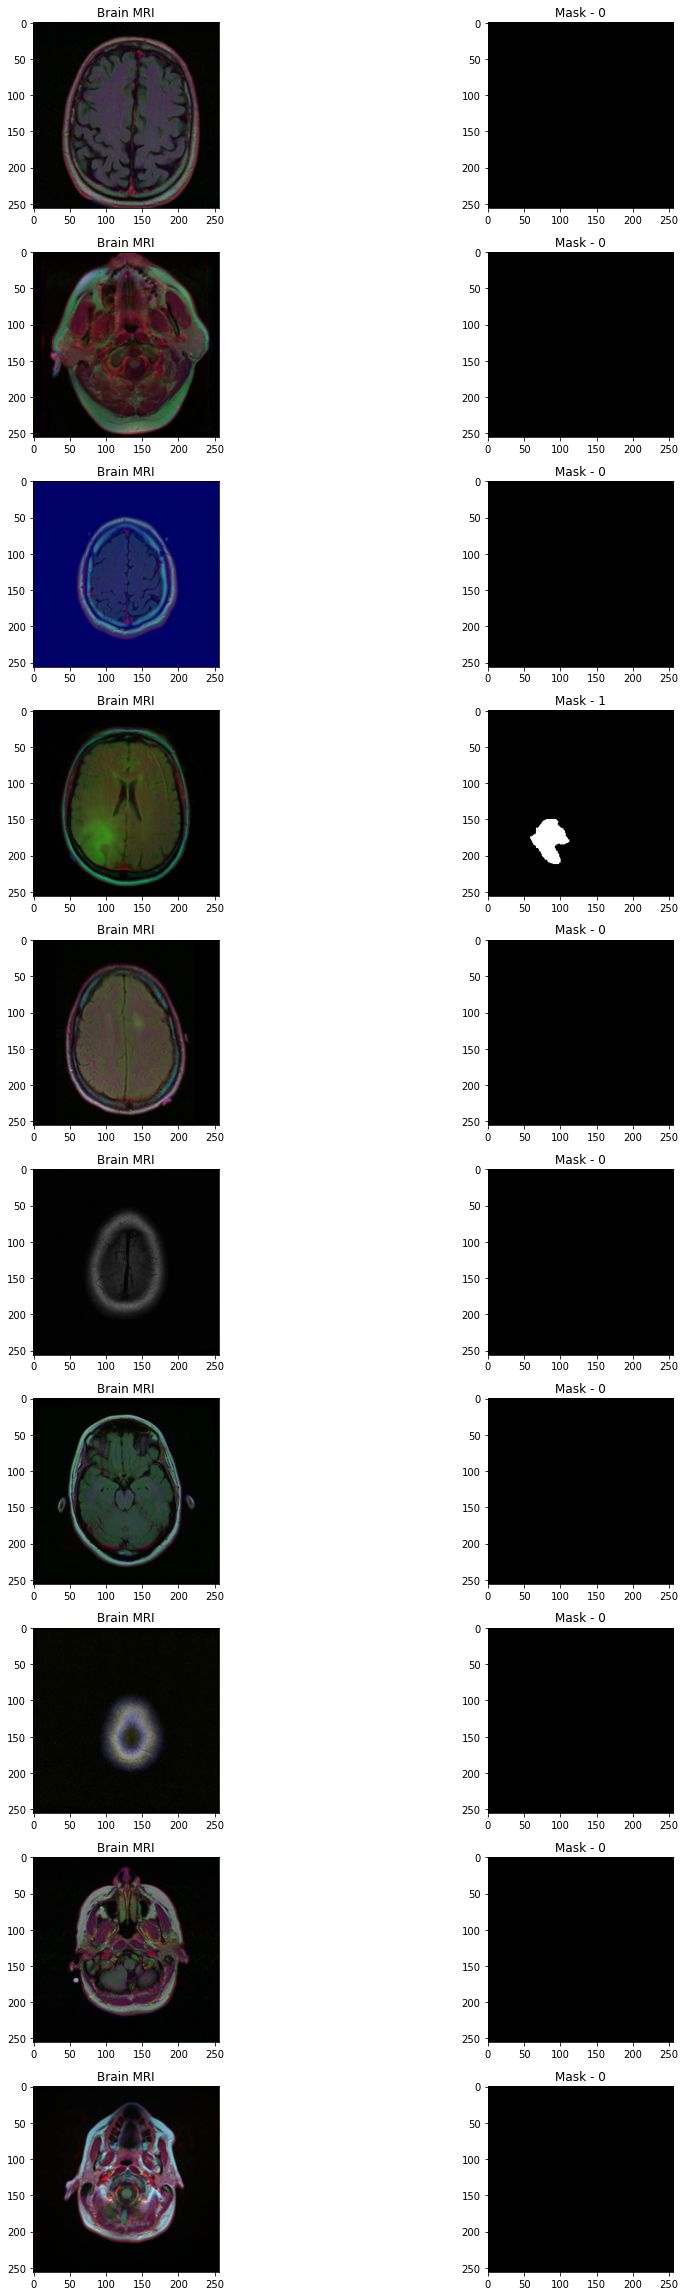

In [25]:
import random
fig, axs = plt.subplots(10,2, figsize=(16,32))
count = 0
for x in range(10):
  i = random.randint(0, len(brain_df)) # selecting a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

# Above figures show the Visualization of the images The MRI and The Mask in our dataset separately




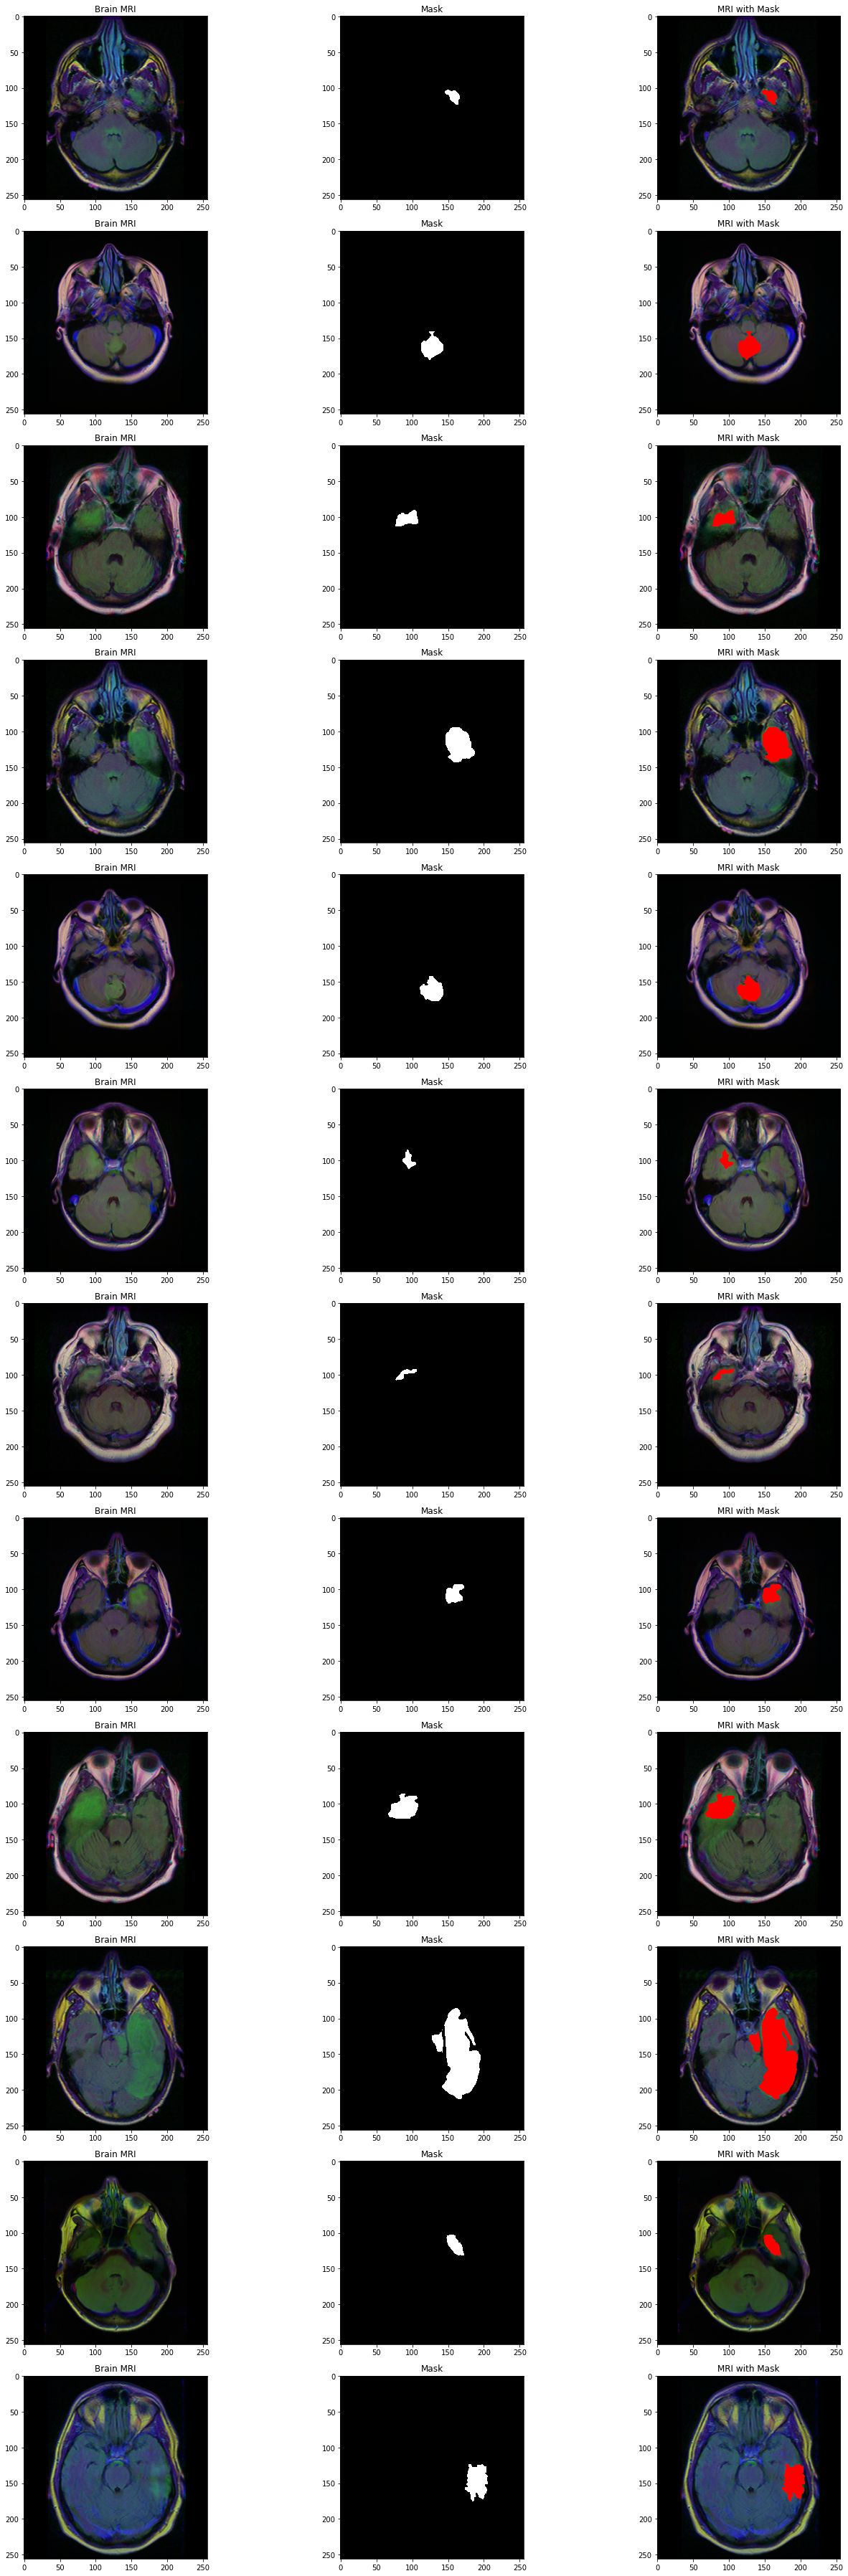

In [26]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

In [27]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [29]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

Here we are converting the data in mask column to string format to use categorical mode in flow_from_dataframe. We will get this error message if we comment out the following code line:
TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.


In [30]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [31]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [32]:
# creating an image generator
from keras_preprocessing.image import ImageDataGenerator

# Creating a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [33]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Creating a data generator for test images

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [30]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [31]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [32]:
for layer in basemodel.layers:
  layers.trainable = False

In [33]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

We are adding our classification head to the base model



In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [35]:
#model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [36]:
model.compile(loss = 'categorical_crossentropy', optimizer='SGD', metrics= ["accuracy"])

In [37]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [40]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 18, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/18
177/177 [==============================] - 98s 508ms/step - loss: 0.5358 - accuracy: 0.7181 - val_loss: 1.3345 - val_accuracy: 0.6452

Epoch 00001: val_loss improved from inf to 1.33455, saving model to classifier-resnet-weights.hdf5
Epoch 2/18
177/177 [==============================] - 87s 490ms/step - loss: 0.2690 - accuracy: 0.8842 - val_loss: 1.4309 - val_accuracy: 0.6431

Epoch 00002: val_loss did not improve from 1.33455
Epoch 3/18
177/177 [==============================] - 87s 489ms/step - loss: 0.1393 - accuracy: 0.9501 - val_loss: 1.2048 - val_accuracy: 0.6411

Epoch 00003: val_loss improved from 1.33455 to 1.20478, saving model to classifier-resnet-weights.hdf5
Epoch 4/18
177/177 [==============================] - 87s 490ms/step - loss: 0.1138 - accuracy: 0.9631 - val_loss: 0.8256 - val_accuracy: 0.6774

Epoch 00004: val_loss improved from 1.20478 to 0.82560, saving model to classifier-resnet-weights.hdf5
Epoch 5/18
177/177 [==============================] - 86s 48

In [41]:
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [42]:
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='SGD', metrics= ["accuracy"])

In [43]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 6s 154ms/step


In [44]:
test_predict.shape

(576, 2)

In [45]:
test_predict

array([[1.0000000e+00, 7.1332579e-10],
       [1.5672066e-08, 1.0000000e+00],
       [9.9994969e-01, 5.0345785e-05],
       ...,
       [9.9998891e-01, 1.1092723e-05],
       [9.9921322e-01, 7.8675384e-04],
       [9.9999833e-01, 1.6731827e-06]], dtype=float32)

In [46]:
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [47]:
predict

array(['0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0',
       '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0',
       '1', '0', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '0',
       '0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1',
       '0', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1', '0', '1',
       '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0',
       '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0',
       '1', '0', '0', '0', '0', '0', '1', '1', '1', '0', '1', '1', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1',
       '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0',
       '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0

In [48]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [49]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9895833333333334

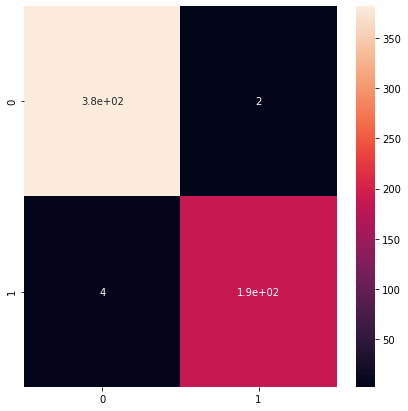

In [50]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [51]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       384
           1       0.99      0.98      0.98       192

   micro avg       0.99      0.99      0.99       576
   macro avg       0.99      0.99      0.99       576
weighted avg       0.99      0.99      0.99       576



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [52]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [53]:
brain_df_mask.head()

patient_id  ... mask
445  TCGA_DU_5872_19950223  ...    1
507  TCGA_DU_5874_19950510  ...    1
551  TCGA_DU_5854_19951104  ...    1
555  TCGA_DU_5854_19951104  ...    1
617  TCGA_DU_5853_19950823  ...    1

[5 rows x 4 columns]

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [55]:
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [56]:
from utilities import DataGenerator


training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [57]:
def resblock(X, f):
  
  X_copy = X


  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)


  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)


  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [58]:
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [59]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [60]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
____________________________________________________________________________________________

In [61]:
from utilities import focal_tversky, tversky_loss, tversky

In [62]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [63]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [64]:
history = model_seg.fit(training_generator, epochs = 10, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/10
72/72 [==============================] - 604s 8s/step - loss: 0.8582 - tversky: 0.1833 - val_loss: 0.7533 - val_tversky: 0.3140

Epoch 00001: val_loss improved from inf to 0.75333, saving model to ResUNet-weights.hdf5
Epoch 2/10
72/72 [==============================] - 35s 492ms/step - loss: 0.5262 - tversky: 0.5725 - val_loss: 0.5583 - val_tversky: 0.5391

Epoch 00002: val_loss improved from 0.75333 to 0.55832, saving model to ResUNet-weights.hdf5
Epoch 3/10
72/72 [==============================] - 29s 396ms/step - loss: 0.3931 - tversky: 0.7097 - val_loss: 0.6863 - val_tversky: 0.3941

Epoch 00003: val_loss did not improve from 0.55832
Epoch 4/10
72/72 [==============================] - 29s 395ms/step - loss: 0.3401 - tversky: 0.7607 - val_loss: 0.3239 - val_tversky: 0.7738

Epoch 00004: val_loss improved from 0.55832 to 0.32387, saving model to ResUNet-weights.hdf5
Epoch 5/10
72/72 [==============================] - 29s 395ms/step - loss: 0.3074 - tversky: 0.7913 - val_lo

In [65]:
model_json1 = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file1:
  json_file1.write(model_json1)

In [66]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file1:
    json_savedModel1= json_file1.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel1)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [67]:
from utilities import prediction


image_id, mask, has_mask = prediction(test, model, model_seg)

In [68]:
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  ... has_mask
0    TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_7.tif  ...        0
1    TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_30...  ...        1
2    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_14...  ...        0
3    TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  ...        0
4    TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_17...  ...        0
..                                                 ...  ...      ...
585  TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_16...  ...        0
586  TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_22...  ...        1
587  TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_6.tif  ...        0
588  TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_25...  ...        0
589  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_32...  ...        1

[590 rows x 3 columns]

In [69]:
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()
#len(df_pred)

image_path  ... has_mask
0  TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_7.tif  ...        0
1  TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_30...  ...        1
2  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_14...  ...        0
3  TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  ...        0
4  TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_17...  ...        0

[5 rows x 5 columns]

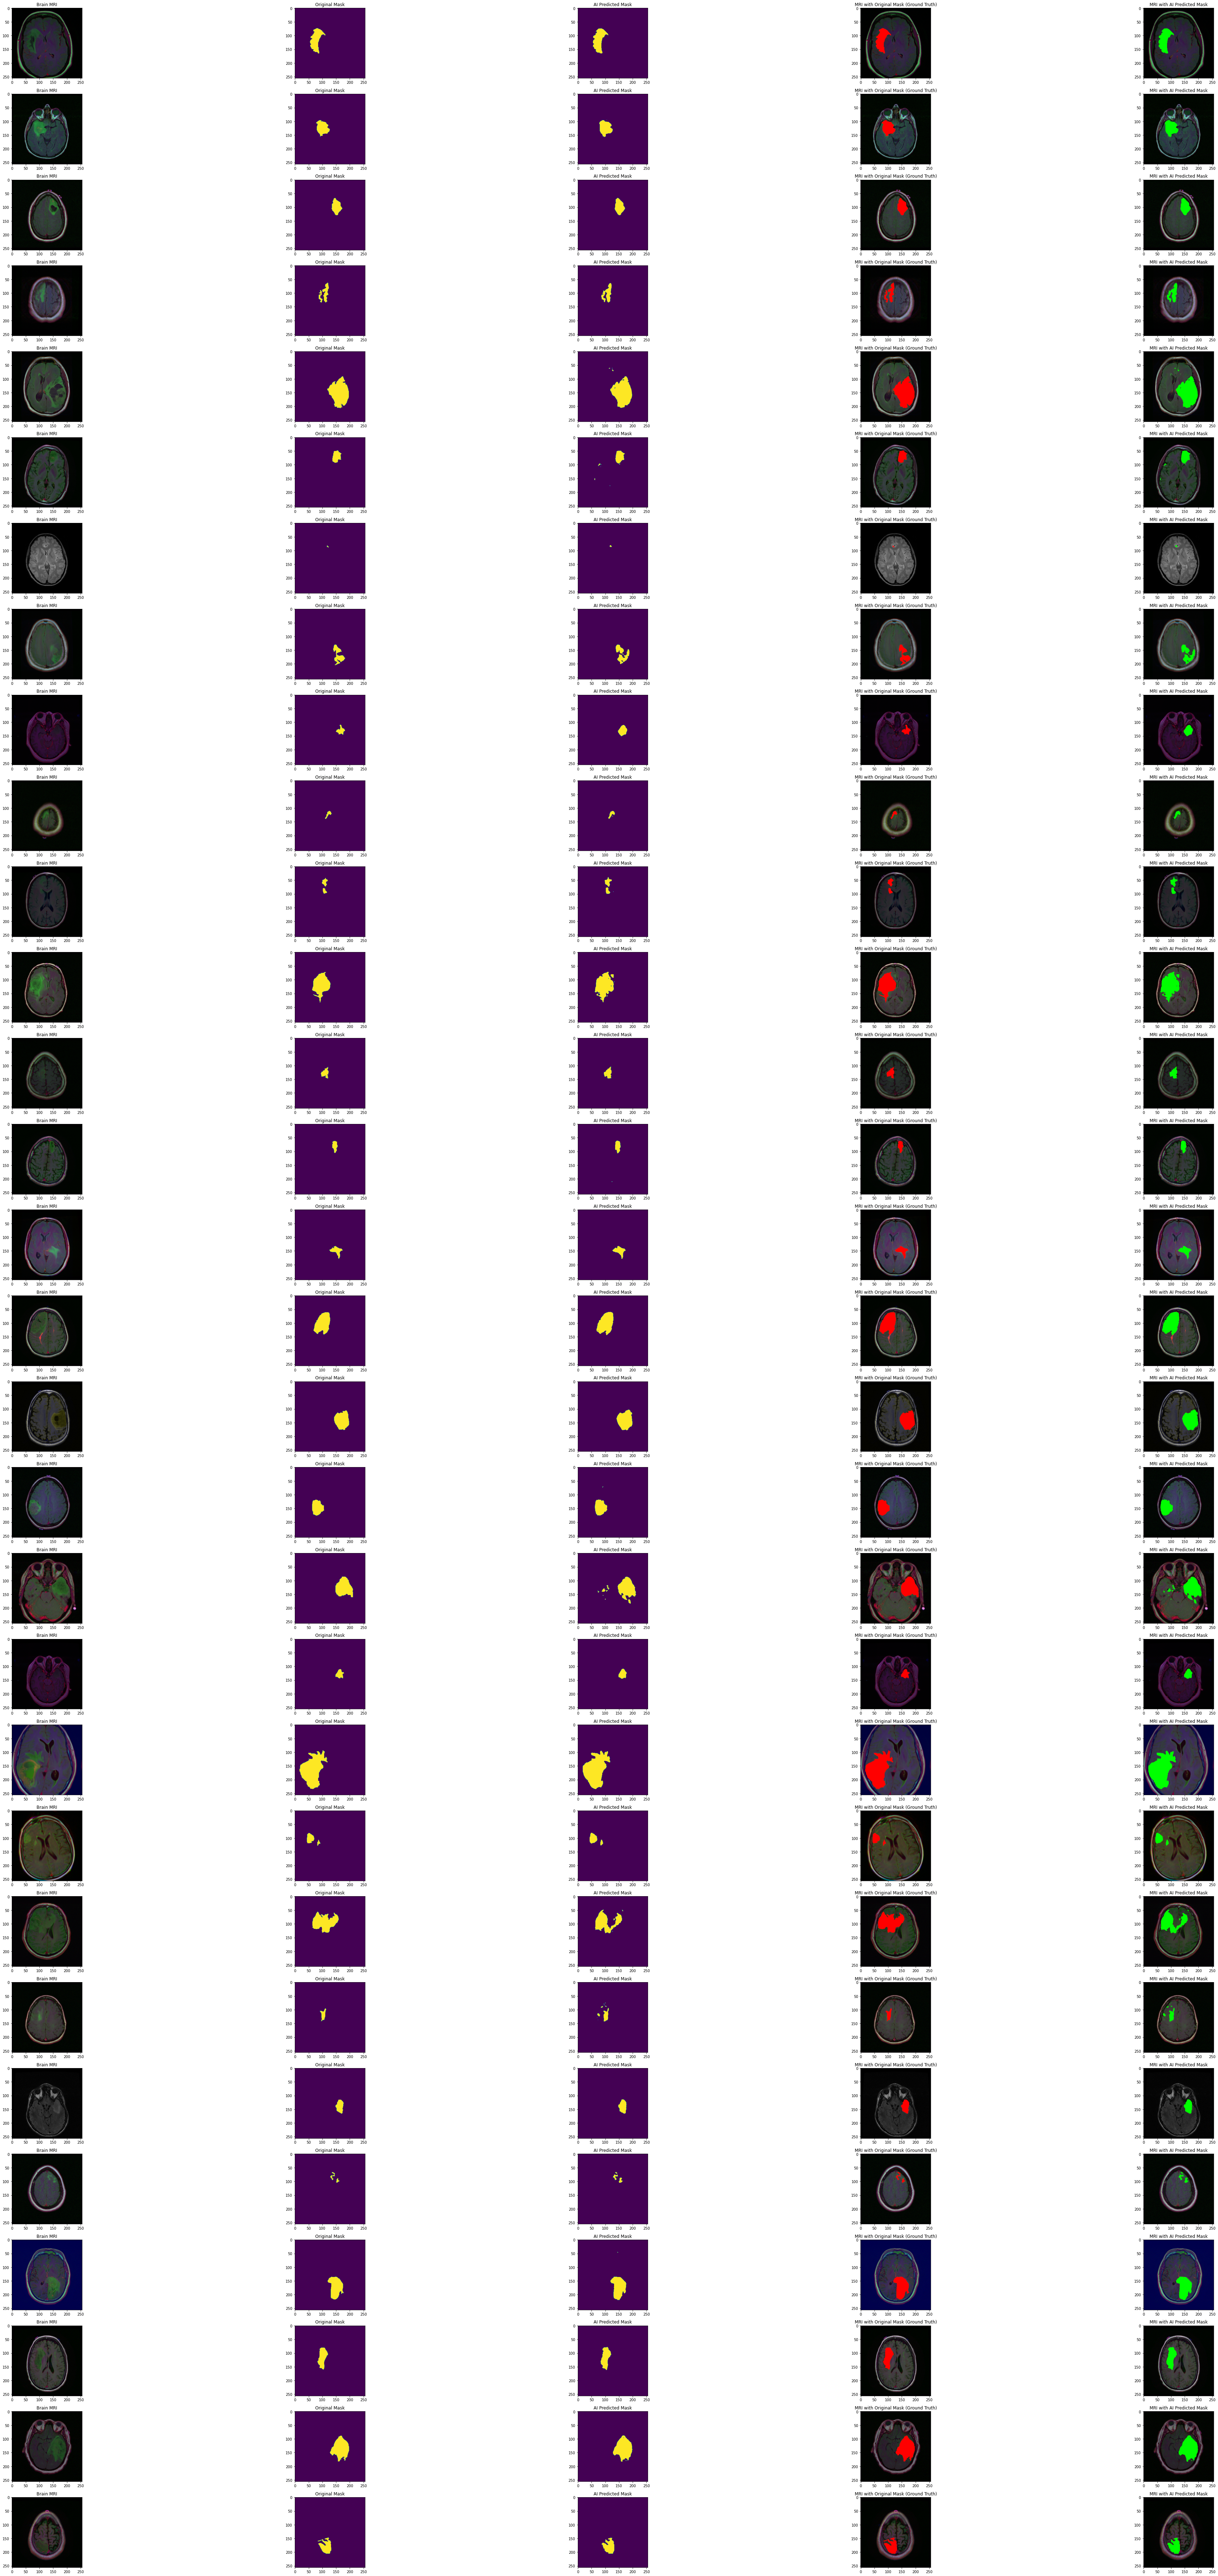

In [70]:
count = 0 
fig, axs = plt.subplots(30, 5, figsize=(60, 100))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 30:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

We have plotted the 30 brain tumored test images in to the machine and have gotten the highly predicted, accurate and presized location of the mask with green colored output.